In [1]:
from FVG import FVGStrategy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tqdm

import warnings
warnings.filterwarnings("ignore")


import_search = True

# Functions

In [2]:
# traders
def go_long(cash_balance, btc_units, btc_close, long_position, transaction_fee, rf):
    # first update cash balance with todays interest
    cash_balance = cash_balance * (1+rf)

    # get the portfolio value
    portfolio_value = cash_balance + btc_units*btc_close

    # we must not be in a position that is not as long as the one we are going into. if not, it is impossible to go long
    current_position = (btc_units*btc_close) / portfolio_value
    if current_position > long_position:
        # print('Could not go Long on ' + str(date))
        return cash_balance, btc_units

    # go long
    target_cash = (1-long_position) * portfolio_value

    # get ammount of cash that can be invested
    cash_to_invest = cash_balance - target_cash

    # secondary checker
    assert cash_to_invest >= 0

    # buy btc
    btc_to_buy = (cash_to_invest / btc_close) * (1-transaction_fee)
    btc_units +=btc_to_buy

    # return new cash balance and btc units in portfolio
    return target_cash, btc_units

def go_short(cash_balance, btc_units, btc_close, short_position, transaction_fee, rf):
    
    # first update cash balance
    cash_balance = cash_balance * (1+rf)

    # get the portfolio value
    portfolio_value = cash_balance + btc_units*btc_close

    # we must not be in a position that is as short as the one we are going into. if not, it is impossible to go short
    current_position = (btc_units*btc_close) / portfolio_value
    if current_position < short_position:
        # print('Could not go Short on ' + str(date))
        return cash_balance, btc_units

    # go short
    target_btc_units = (short_position * portfolio_value)/btc_close

    # get ammount of btc to sell (units)
    btc_to_sell = btc_units - target_btc_units
    assert btc_to_sell >= 0

    # calculate cash from selling that many units of btc
    cash_from_sale = btc_to_sell * btc_close * (1-transaction_fee)

    # update cash balance
    cash_balance += cash_from_sale

    return cash_balance, target_btc_units

def hold(cash_balance, rf):

    # add interest 
    cash_balance = cash_balance * (1+rf)

    return cash_balance

def simmulate(
                df : pd.DataFrame, 
                initial_cash : float = 0, 
                btc_value : float = 100,
                long_position : float = 1, 
                short_position : float = 0, 
                transaction_fee : float = 0.001, 
                max_drawdown_threshold : float = 0.4, 
                drawdown_buffer : float = 0.05
              ) -> pd.DataFrame:
    # results
    days = []

    # tracker variables
    cash_balance = initial_cash
    btc_units = btc_value / df.loc[0, 'Close']

    # btc drawdown helper
    btc_max = df.loc[0, 'Close']

    # portfolio drawdown helper
    portfolio_max = cash_balance + btc_units * df.loc[0, 'Close']

    # drawdown protection helper
    in_drawdown_protection_mode = False

    for i in df.index:
        row = df.iloc[i]
        # initialise day stats
        day ={
            'Date': row['Date']
        }
        # update btc max and keep track of BTC drawdown
        btc_max = max(btc_max, row['Close'])
        day['BTC Drawdown'] = (btc_max - row['Close']) / btc_max

        # get signal
        signal = row['Signal']
        day['Signal'] = signal

        # check if we need to enter drawdown protection mode
        if not in_drawdown_protection_mode and day['BTC Drawdown'] > max_drawdown_threshold:
            in_drawdown_protection_mode = True
            day['Protection Mode'] = True
            # go short
            cash_balance, btc_units = go_short(
                cash_balance = cash_balance, 
                btc_units = btc_units, 
                btc_close = row['Close'], 
                short_position = short_position, 
                transaction_fee = transaction_fee, 
                rf = row['Risk Free Rate'])
            day['Signal'] = -1
        
        elif in_drawdown_protection_mode:
            # Case 1 : BTC Drawdown is less than the max drawdown threshold - drawdown buffer so we exit protection mode and go long
            if day['BTC Drawdown'] < (max_drawdown_threshold - drawdown_buffer):
                in_drawdown_protection_mode = False
                day['Protection Mode'] = False

                # go long
                cash_balance, btc_units = go_long(
                    cash_balance = cash_balance, 
                    btc_units = btc_units,
                    btc_close = row['Close'],
                    long_position = long_position,
                    transaction_fee = transaction_fee,
                    rf = row['Risk Free Rate'])
                day['Signal'] = 1
                
            else:
                day['Protection Mode'] = True
                cash_balance = hold(cash_balance=cash_balance, rf=row['Risk Free Rate'])
                if signal == 1:  # Buy signal
                    cash_balance, btc_units = go_long(
                        cash_balance=cash_balance, 
                        btc_units=btc_units,
                        btc_close=row['Close'],
                        long_position=long_position,  
                        transaction_fee=transaction_fee,
                        rf=row['Risk Free Rate'])
                elif signal == -1:  # Sell signal
                    cash_balance, btc_units = go_short(
                        cash_balance=cash_balance, 
                        btc_units=btc_units, 
                        btc_close=row['Close'], 
                        short_position=short_position,  
                        transaction_fee=transaction_fee, 
                        rf=row['Risk Free Rate'])
                else:  
                    cash_balance = hold(cash_balance=cash_balance, rf=row['Risk Free Rate'])


        


        # if we have to buy we shift to a long position
        elif signal == 1: # buy signal
            in_drawdown_protection_mode = False
            day['Protection Mode'] = in_drawdown_protection_mode
            
            cash_balance, btc_units = go_long(
                cash_balance = cash_balance, 
                btc_units = btc_units, 
                btc_close = row['Close'], 
                long_position = long_position, 
                transaction_fee = transaction_fee, 
                rf = row['Risk Free Rate'])
        # if we have to sell we shift to a short position
        elif signal == -1: # sell signal
            day['Protection Mode'] = False
            cash_balance, btc_units = go_short(
                cash_balance = cash_balance, 
                btc_units = btc_units, 
                btc_close = row['Close'], 
                short_position=short_position, 
                transaction_fee = transaction_fee, 
                rf = row['Risk Free Rate'])
        # if we have to hold, it only affects the cash balance
        elif signal == 0: # hold signal
            day['Protection Mode'] = False
            cash_balance = hold(cash_balance=cash_balance, rf=row['Risk Free Rate'])

        # update balances
        day['Cash Balance'] = cash_balance
        day['BTC Balance'] = btc_units * row['Close']
        day['Portfolio Value'] = day['Cash Balance'] + day['BTC Balance']
        
        # update portfolio max and keep track of portfolio drawdown
        portfolio_max = max(portfolio_max, day['Portfolio Value'])
        day['Portfolio Drawdown'] = (portfolio_max - day['Portfolio Value']) / portfolio_max
        

        days.append(day)

        
    
    days = pd.DataFrame(days)
    # get portfolio value under strategy
    days['Portfolio Value'] = days['Cash Balance'] + days['BTC Balance']
    # get buy and hold portfolio value
    days['Buy and Hold Value'] = ((initial_cash+btc_value) / df.loc[0, 'Close']) * df['Close']

    # add risk free rate
    days['Risk Free Rate'] = df['Risk Free Rate']

    return days




In [3]:
# plotters
def plot_portfolio_with_signals(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(16, 6))
    plt.plot(df['Date'], df['Portfolio Value'], label='Portfolio Value', color='blue')
    plt.plot(df['Date'], df['Buy and Hold Value'], label='Buy and Hold Value', color='orange')
    
    # Markers for buy/sell signals
    buy_signals = df[df['Signal'] == 1]
    sell_signals = df[df['Signal'] == -1]
    
    plt.scatter(buy_signals['Date'], buy_signals['Portfolio Value'], marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(sell_signals['Date'], sell_signals['Portfolio Value'], marker='v', color='red', label='Sell Signal', s=100)
    
    plt.title('Portfolio Value Over Time with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_drawdown(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(16, 4))
    plt.plot(df['Date'], df['BTC Drawdown'], color='orange', label='BTC Drawdown')
    plt.plot(df['Date'], df['Portfolio Drawdown'], color='blue', label='Portfolio Drawdown')
    plt.title('BTC Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_protection_mode(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(16, 4))
    plt.plot(df['Date'], df['Protection Mode'], color='red', label='Protection Mode')
    plt.title('Protection Mode Over Time')
    plt.xlabel('Date')
    plt.ylabel('Protection Mode')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [4]:
# reporter
def generate_report(results, verbose=False):
    # calculate total return
    strategy_total_return = results['Portfolio Value'].iloc[-1] / results['Portfolio Value'].iloc[0]
    buy_and_hold_total_return = results['Buy and Hold Value'].iloc[-1] / results['Buy and Hold Value'].iloc[0]

    # annualise the returns based on the number of days in the dataset
    days = (results['Date'].iloc[-1] - results['Date'].iloc[0]).days
    strategy_total_return = (1+strategy_total_return)**(365/days) - 1
    buy_and_hold_total_return = (1+buy_and_hold_total_return)**(365/days) - 1

    strategy_tr_improvement = ((strategy_total_return - buy_and_hold_total_return) / buy_and_hold_total_return) * 100



    # calculate sharpe ratio
    strategy_return = results['Portfolio Value'].pct_change()
    strategy_excess_return = strategy_return - results['Risk Free Rate']
    # annualise the returns
    # strategy_excess_return = (1+strategy_excess_return)**365
    strategy_sharpe_ratio = strategy_excess_return.mean() / strategy_return.std()

    buy_and_hold_return = results['Buy and Hold Value'].pct_change()
    buy_and_hold_excess_return = buy_and_hold_return - results['Risk Free Rate']
    # annualise the returns
    # buy_and_hold_excess_return = (1+buy_and_hold_excess_return)**365
    buy_and_hold_sharpe_ratio = buy_and_hold_excess_return.mean() / buy_and_hold_return.std()

    strategy_sharpe_improvement = ((strategy_sharpe_ratio - buy_and_hold_sharpe_ratio) / buy_and_hold_sharpe_ratio) * 100



    # calculate max drawdown
    strategy_max_drawdown = results['Portfolio Drawdown'].max()
    buy_and_hold_max_drawdown = results['BTC Drawdown'].max()

    strategy_max_drawdown_improvement = ((strategy_max_drawdown - buy_and_hold_max_drawdown) / buy_and_hold_max_drawdown) * 100



    # signals
    buy_signals = results[results['Signal'] == 1].shape[0]
    sell_signals = results[results['Signal'] == -1].shape[0]
    hold_signals = results[results['Signal'] == 0].shape[0]


    # average gap between portfolio and buy and hold value
    gap = results['Portfolio Value'] - results['Buy and Hold Value']
    gap_pct = gap / results['Buy and Hold Value']*100
    average_gap = gap.mean()
    average_gap_pct = gap_pct.mean()
    std_gap = gap.std()
    std_gap_pct = gap_pct.std()

    # print a well formatted report
    if verbose:
        print('REPORT')
        print('--------------------------------')
        print(f"Date Range: {results['Date'].iloc[0]} - {results['Date'].iloc[-1]}")
        print('--------------------------------')
        print(f"Strategy Total Return: {strategy_total_return:.2%}")
        print(f"Buy and Hold Total Return: {buy_and_hold_total_return:.2%}")
        print(f"Strategy Improvement (%) : {strategy_tr_improvement:.2f}%")
        print('--------------------------------')
        print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.2f}")
        print(f"Buy and Hold Sharpe Ratio: {buy_and_hold_sharpe_ratio:.2f}")
        print(f"Strategy Improvement (%) : {strategy_sharpe_improvement:.2f}%")
        print('--------------------------------')
        print(f"Strategy Max Drawdown: {strategy_max_drawdown:.2%}")
        print(f"Buy and Hold Max Drawdown: {buy_and_hold_max_drawdown:.2%}")
        print(f"Strategy Improvement (%) : {strategy_max_drawdown_improvement:.2f}%")
        print('--------------------------------')
        print(f'# Buy Signals: {buy_signals}')
        print(f'# Sell Signals: {sell_signals}')
        print(f'# Hold Signals: {hold_signals}')
        print('--------------------------------')
        print(f"Average Gap : {average_gap:.2f} ({average_gap_pct:.2f}%)")
        print(f"Standard Deviation of Gap : {std_gap:.2f} ({std_gap_pct:.2f}%)")
    else:
        return {
            'Strategy Total Return': strategy_total_return,
            'Buy and Hold Total Return': buy_and_hold_total_return,
            'Strategy Total Return Improvement': strategy_tr_improvement,
            'Strategy Sharpe Ratio': strategy_sharpe_ratio,
            'Buy and Hold Sharpe Ratio': buy_and_hold_sharpe_ratio,
            'Strategy Sharpe Ratio Improvement': strategy_sharpe_improvement,
            'Strategy Max Drawdown': strategy_max_drawdown,
            'Buy and Hold Max Drawdown': buy_and_hold_max_drawdown,
            'Strategy Max Drawdown Improvement': strategy_max_drawdown_improvement,
            'Buy Signals': buy_signals,
            'Sell Signals': sell_signals,
            'Hold Signals': hold_signals,
            'Average Gap between Portfolio and Buy and Hold Value': average_gap,
            'Standard Deviation of Gap between Portfolio and Buy and Hold Value': std_gap
        }


In [5]:
def grid_search(df, rf, save=False):
    results = []
    for lookback_period in tqdm.tqdm(np.linspace(10, 50, 3)):
        for body_multiplier in np.linspace(1, 2, 3):
            for backcandles in np.linspace(30, 60, 3):
                for test_candles in np.linspace(5, 15, 3):
                    # for max_drawdown_threshold in np.linspace(0.2, 0.6, 3):
                            
                            strategy = FVGStrategy(lookback_period=int(lookback_period), body_multiplier=body_multiplier, backcandles=int(backcandles), test_candles=int(test_candles))
                            signals = strategy.generate_signals(df)
                            signals['Risk Free Rate'] = (1 + rf) ** (1/365) - 1
                            signals['Date'] = pd.to_datetime(signals['Date'])
                            # simulate
                            result = simmulate(signals, max_drawdown_threshold=0.4, drawdown_buffer=0.05)
                            # generate report
                            report = generate_report(result)
                            # add to results
                            params = {
                                'lookback_period': lookback_period,
                                'body_multiplier': body_multiplier,
                                'backcandles': backcandles,
                                'test_candles': test_candles,
                                # 'max_drawdown_threshold': max_drawdown_threshold,
                                **report
                            }
                            results.append(params)
                        
    #                     # jump out of all loops
    #                     break
    #                 break
    #             break
    #         break
    #     break
    # break


    results = pd.DataFrame(results).sort_values(by='Strategy Total Return', ascending=False)
    
    if save:
        results.to_csv('results.csv', index=False)

    params = results.iloc[0, :4]

    return params

# Run Initial

In [6]:
df = pd.read_csv('/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/Data.csv')
df.dropna(inplace=True)
df.reset_index(inplace=True)

rf = df['Risk Free Rate']
btc = df.drop(columns=['Risk Free Rate'])

params = [10, 2, 30, 5]
# strategy = FVGStrategy(lookback_period=10, body_multiplier=1.2, backcandles=50, test_candles=15)
strategy = FVGStrategy(*params)
signals_df = strategy.generate_signals(btc)



signals_df['Risk Free Rate'] = (1 + rf) ** (1/365) - 1
signals_df.head()



Detecting Break Signals: 100%|██████████| 3561/3561 [00:00<00:00, 102294.49it/s]

Signal Generation Complete


,index,Date,Open,High,Low,Close,Volume,FVG,key_levels,Signal,Risk Free Rate
0,0,2015-07-20,277.98,280.00,277.37,280.00,782.883420,None,None,0,0.000064
1,1,2015-07-21,279.96,281.27,276.85,277.32,4943.559434,None,None,0,0.000063
2,2,2015-07-22,277.33,278.54,275.01,277.89,4687.909383,None,None,0,0.000063
3,3,2015-07-23,277.96,279.75,276.28,277.39,5306.919575,None,None,0,0.000062
4,4,2015-07-24,277.23,291.52,276.43,289.12,7362.469083,None,None,0,0.000062


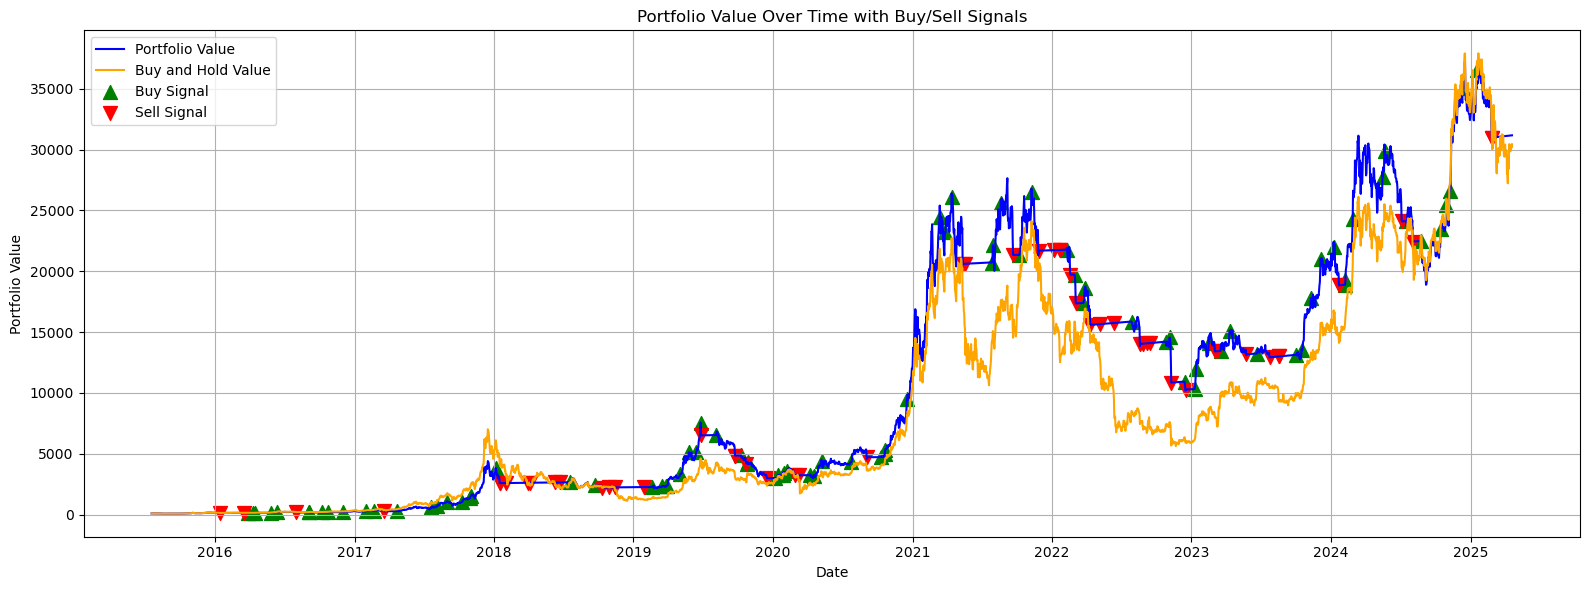

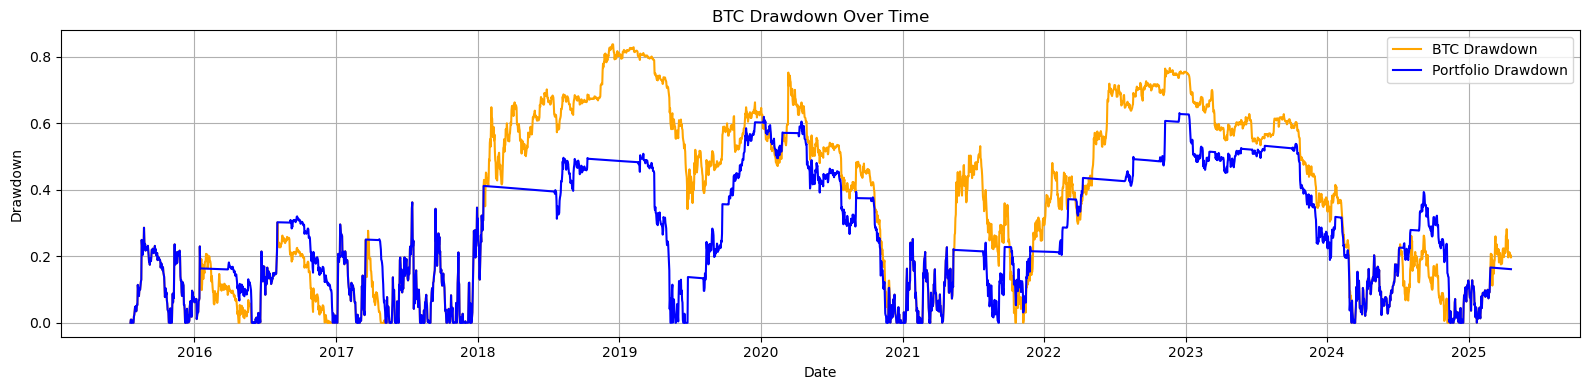

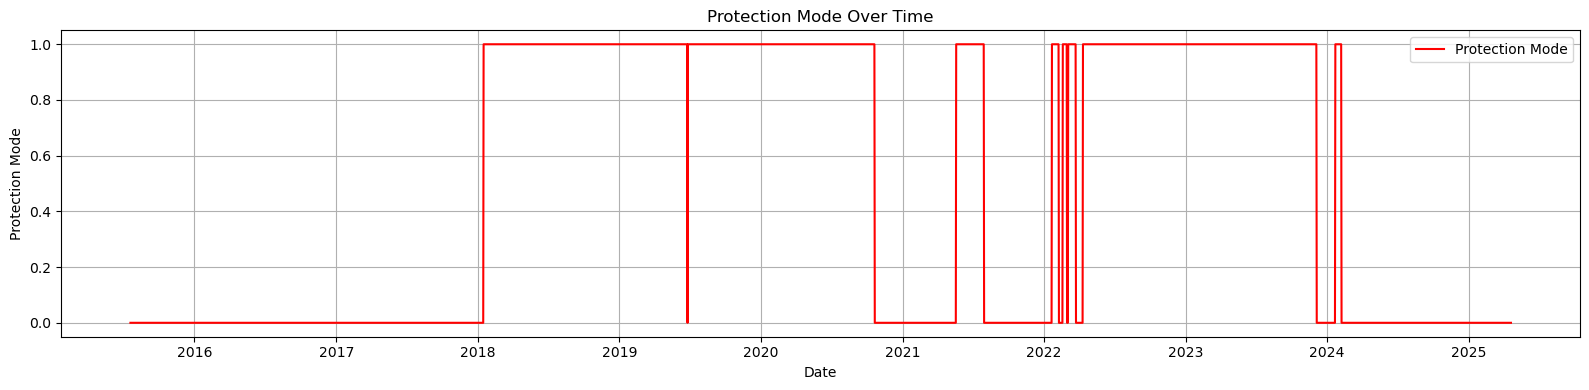

REPORT
--------------------------------
Date Range: 2015-07-20 00:00:00 - 2025-04-19 00:00:00
--------------------------------
Strategy Total Return: 80.20%
Buy and Hold Total Return: 79.76%
Strategy Improvement (%) : 0.55%
--------------------------------
Strategy Sharpe Ratio: 0.07
Buy and Hold Sharpe Ratio: 0.06
Strategy Improvement (%) : 13.43%
--------------------------------
Strategy Max Drawdown: 63.10%
Buy and Hold Max Drawdown: 83.80%
Strategy Improvement (%) : -24.70%
--------------------------------
# Buy Signals: 86
# Sell Signals: 53
# Hold Signals: 3423
--------------------------------
Average Gap : 1885.25 (19.33%)
Standard Deviation of Gap : 2560.79 (35.19%)


In [7]:
result = simmulate(signals_df[['Date','Close' ,'Signal', 'Risk Free Rate']], 
                   initial_cash=0, btc_value=100, 
                   long_position=1, short_position=0, transaction_fee=0.001, 
                   max_drawdown_threshold=0.4, drawdown_buffer=0.05)

# plot results
plot_portfolio_with_signals(result)
plot_drawdown(result)
plot_protection_mode(result)

# generate report
report = generate_report(result, verbose=True)

# Grid Search (Bitcoin)

In [8]:
df = pd.read_csv('/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/Data/BTC.csv')
df.dropna(inplace=True)
df.reset_index(inplace=True)

rf = df['Risk Free Rate']
df = df.drop(columns=['Risk Free Rate'])

# grid search
if not import_search:
    grid_search(df, rf)
